In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

from models.bayes import *
from process.config import *
from process.measurements import *

### Load Data and Filter Time

In [2]:
index_year = 2016
day_gap = 0
min_labs = 5
percent_cutoff = 0.80

measurements = pd.read_csv('../data/processed/all_lab_measurements.csv')[['subject_id', 'time', 'test_name', 'numeric_value', 'gender_concept_id', 'age']].sort_values(by=['subject_id', 'test_name', 'time'])
measurements['sex'] = measurements['gender_concept_id'].map(lambda x: 'M' if x == 0 else 'F')

# Process with both filtering methods
#processed_df_filter = filter_measurements_df(measurements, index_year=index_year, day_gap=day_gap, min_pre_tests=min_pre_tests)
processed_df_cutoff = cutoff_measurements_df(measurements, percent_cutoff=percent_cutoff, min_pre_tests=min_labs)

# Use the cutoff version
processed_df = processed_df_cutoff
display(processed_df.head())

statistics = get_subject_stats(processed_df)
display(statistics.head())

,subject_id,time,test_name,numeric_value,gender_concept_id,age,sex
3635696,115967095,2008-10-08 01:11:00,BUN,16.0,1,74.795346,F
3635715,115967095,2008-10-08 08:10:00,BUN,13.0,1,74.795346,F
3635751,115967095,2008-10-09 05:05:00,BUN,11.0,1,74.798084,F
3635778,115967095,2008-10-10 06:05:00,BUN,10.0,1,74.800821,F
3635795,115967095,2008-10-11 06:40:00,BUN,10.0,1,74.803559,F


Calculating statistics: 100%|██████████| 72925/72925 [01:23<00:00, 868.58it/s]


,subject_id,test_name,sex,age,num_measurements,last_time,time_period_days,obs_mean,obs_var
0,115967095,BUN,F,74.809035,7,2008-10-13 06:56:00,5,11.571429,4.952381
1,115967095,CA,F,74.809035,7,2008-10-13 06:56:00,5,7.285714,0.078095
2,115967095,CL,F,74.809035,7,2008-10-13 06:56:00,5,100.428571,6.952381
3,115967095,CO2,F,74.809035,7,2008-10-13 06:56:00,5,24.571429,3.952381
4,115967095,CRE,F,74.809035,7,2008-10-13 06:56:00,5,0.671429,0.009048


### Empirical Bayes Model

In [1]:
priors = {}
for test, intervals in REFERENCE_INTERVALS.items():
    for sex, (lower, upper, unit) in intervals.items():
        key = (test, sex)
        priors[key] = {
            'mean': (lower + upper) / 2,
            'var': ((upper - lower) / 4)**2
        }
min_labs = 5
method_str = f'cutoff_{percent_cutoff}_min_{min_labs}'
statistics = apply_empirical_bayes(statistics, prior_method='reference', priors=priors)
statistics.to_csv(f'../results/bayes/bayes_reference_prior_{method_str}.csv', index=False)
plot_empirical_bayes(statistics, 'RBC')

statistics = apply_empirical_bayes(statistics, prior_method='empirical', priors=priors)
plot_empirical_bayes(statistics, 'RBC')


NameError: name 'REFERENCE_INTERVALS' is not defined

# Heirarchical Bayes

In [4]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

# Prepare data
obs_mean = rbc_stats['obs_mean'].values
obs_var = rbc_stats['obs_variance'].values
n_obs = rbc_stats['num_measurements'].values
adjusted_var = obs_var / n_obs
adjusted_sd = np.sqrt(adjusted_var)

N = len(obs_mean)

# Define the model
with pm.Model() as model:
    # Hyperpriors
    mu0 = pm.Normal("mu0", mu=5, sigma=1)
    tau = pm.HalfNormal("tau", sigma=0.5)

    # Latent variables
    theta = pm.Normal("theta", mu=mu0, sigma=tau, shape=N)

    # Observed data
    y_obs = pm.Normal("obs", mu=theta, sigma=adjusted_sd, observed=obs_mean)

    # Variational Inference
    approx = pm.fit(
        n=5000,
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)],
        progressbar=True
    )

    # Plot ELBO convergence
    plt.plot(approx.hist)
    plt.ylabel("ELBO")
    plt.xlabel("Iteration")
    plt.title("ELBO Convergence during ADVI")
    plt.show()

    # Draw posterior samples from variational approximation
    trace = approx.sample(5000)

# Summarize the results
az.summary(trace, var_names=["mu0", "tau", "theta"])


NameError: name 'rbc_stats' is not defined

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


Estimated mu0: 4.6080
Estimated tau: 0.7780


(<Figure size 800x900 with 1 Axes>,
 <Axes: title={'center': 'Empirical Bayes for RBC'}, xlabel='RBC Value', ylabel='Subject'>)

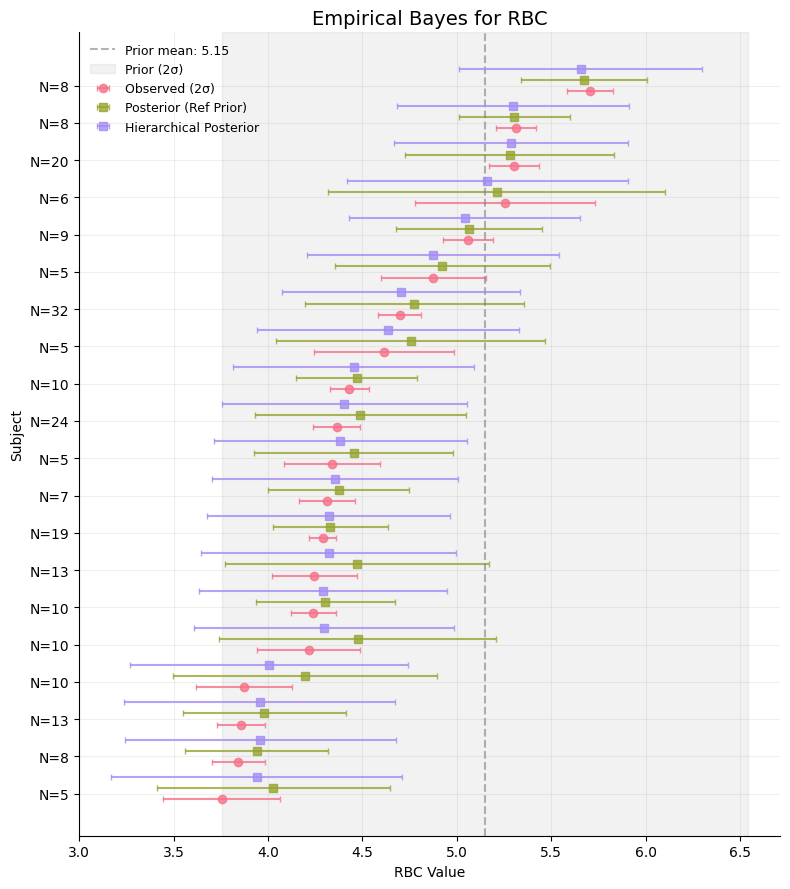

In [19]:
trace_df = az.summary(trace, var_names=["mu0", "tau", "theta"])
trace_df = pd.DataFrame(trace_df)

# print estimated parameters for mu0 and tau (first two rows)
print(f"Estimated mu0: {trace_df['mean'].values[0]:.4f}")
print(f"Estimated tau: {trace_df['mean'].values[1]:.4f}")

trace_df = trace_df[2:]

rbc_stats['hierarchical_post_mu'] = trace_df['mean'].values
rbc_stats['hierarchical_post_var'] = trace_df['sd'].values**2
# plot the results 

hierarchical_sampled_patients = rbc_stats.sample(n_subjects, random_state=42).sort_values('obs_mean').reset_index(drop=True)
plot_empirical_bayes(hierarchical_sampled_patients, 'RBC', n_subjects=20, mu0=5.15, tau2=0.485)